In [22]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import string
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn import tree
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
import matplotlib.pyplot as plt


In [23]:
#creating dataframe from the dataset created in STEP 3
df = pd.read_csv("./enron.csv")
df = df.drop(["Email Folder"], axis=1)
#We will consider the number of emails found in the folders (sent and sent_mail)
#We will train model for different authors by using top authors according to email count.
#We Will consider 5,10 and 15 top authors and train and test model
Authors = df.value_counts(["Folder"])[:5]
#We will drop records where author name is empty or unnamed
df = df.loc[df["Folder"].isin(list(Authors.index.get_level_values(0)))].drop(["Unnamed: 0"], axis=1).reset_index(drop=True)
#We will drop the records if the email content is empty or NA
df = df[df["Text"]!=" "]
df = df[df["Text"]!="\n"]
df = df.dropna()

In [24]:
#This will print the count of top author emails
df["Folder"].value_counts()

mann-k          8167
kaminski-v      5926
dasovich-j      4805
germany-c       4571
shackleton-s    4003
Name: Folder, dtype: int64

In [25]:
#This function will change the records of each author to a number passed in parameter with name of author
def equal_dist(samples_per_author, df):
    df3 = pd.DataFrame(columns=["Author", "Folder", "File", "Text", "Raw Text"]) 
    for folder in df["Folder"].value_counts().index:
        df3 = df3.append(df[df["Folder"]==folder].sample(n=samples_per_author), ignore_index=True)
    return df3
df = equal_dist(4000, df)

#prints the count of each author
print(df["Folder"].value_counts())
#df

mann-k          4000
kaminski-v      4000
dasovich-j      4000
germany-c       4000
shackleton-s    4000
Name: Folder, dtype: int64


/var/folders/zc/s6g9n2xd7y11gw_ngg0r8rx80000gn/T/ipykernel_59331/3434516801.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df3.append(df[df["Folder"]==folder].sample(n=samples_per_author), ignore_index=True)


In [26]:
#Data Cleaning and processing (Remove punction marks, Lemmatization and Stop word removal)
#Lemmatization does morphological analysis of the words.
def Data_cleaning_processing(Data):
    #Remove punction marks
    removedpunc=[char for char in Data if char not in string.punctuation]
    removedpunc=''.join(removedpunc)

    #Lemmatization
    text1=''
    i=0
    Lemmatizer = WordNetLemmatizer()
    for i in range(len(removedpunc.split())):
        #v is verb
        text2=Lemmatizer.lemmatize(removedpunc.split()[i], pos="v")
        text1=text1+text2+' '
        
    #Stop word removal
    output = ""
    for w in text1.split():
        if w.lower():
            w = w.lower()
            if w not in stopwords.words("english"):
                output = output + w + " "
    
    return output

In [27]:
#Data Cleaning and processing 
cleaned_data = df["Text"].apply(lambda r: Data_cleaning_processing(r))
cleaned_data

0        attached revise version consent assignment ver...
1        recall conversations actually series page beli...
2         cant open form im good 50 something enron match 
3                     note calendar michael appt ss today 
4                 im look eggnog skip gummis ill take rum 
                               ...                        
19995                         kim need review letter sara 
19996    give little info topic anyone houston involve ...
19997                                      per voice mail 
19998    dont know anything transactions sara shackleto...
19999    stephanie blue file office mark version ene gu...
Name: Text, Length: 20000, dtype: object

In [28]:
#Adding column to Dataframe
df["cleaned_data"] = cleaned_data
df

,Author,Folder,File,Text,Raw Text,Message ID,cleaned_data
0,Kay,mann-k,1678.0,Attached is a revised version of the consent t...,Message-ID: <19647884.1075845958991.JavaMail.e...,19647884.1075845958991.,attached revise version consent assignment ver...
1,Kay,mann-k,4048.0,I do recall the conversations you and I had (a...,Message-ID: <13576245.1075846018073.JavaMail.e...,13576245.1075846018073.,recall conversations actually series page beli...
2,Kay,mann-k,108.0,"I can't open the form, but I'm good for $50. ...",Message-ID: <8184220.1075846030871.JavaMail.ev...,8184220.1075846030871.,cant open form im good 50 something enron match
3,Kay,mann-k,189.0,I have a note on my calendar that Michael has ...,Message-ID: <3507023.1075846032837.JavaMail.ev...,3507023.1075846032837.,note calendar michael appt ss today
4,Kay,mann-k,2264.0,"I'm looking for the eggnog. Skip the gummis, ...",Message-ID: <73143.1075846084077.JavaMail.evan...,73143.1075846084077.,im look eggnog skip gummis ill take rum
...,...,...,...,...,...,...,...
19995,"Shackleton, Sara",shackleton-s,135.0,Kim: Do I need to review the letters? Sara\n\n,Message-ID: <6965171.1075858808796.JavaMail.ev...,6965171.1075858808796.,kim need review letter sara
19996,Sara,shackleton-s,871.0,Can you give me a little more info on this top...,Message-ID: <4605180.1075844538274.JavaMail.ev...,4605180.1075844538274.,give little info topic anyone houston involve ...
19997,"Shackleton, Sara",shackleton-s,158.0,Per my voice mail\n\n,Message-ID: <17329817.1075858809324.JavaMail.e...,17329817.1075858809324.,per voice mail
19998,Sara,shackleton-s,5737.0,I don't know anything about these transactions...,Message-ID: <17820165.1075844914703.JavaMail.e...,17820165.1075844914703.,dont know anything transactions sara shackleto...


In [29]:
#Labelencoder is used to encode the folder name column and save it in variable as our output label
y = df["Folder"]
LE = LabelEncoder()
Y = LE.fit_transform(y)
Y
# df["Folder"]=y
# df

array([3, 3, 3, ..., 4, 4, 4])

In [30]:
#Train model using Naive Bayes using kfold 10 splits
X = df["cleaned_data"].to_numpy()
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
model = MultinomialNB()
training_accuracy = {k: [] for k in range(2000,24000,2000)}
testing_accuracy = {k: [] for k in range(2000,24000,2000)}
number_features = range(2000, 24000, 2000)
average_training_accuracy = []
average_testing_accuracy = []

In [31]:
#Train model using Naive Bayes using kfold 10 splits
# To select relevant features from all the features produced by Count Vectorizer we are using SelectKBest Features. 
i = 1
for train_index, test_index in kfold.split(X):
    #print(train_index)
    #print(test_index)
    X_train = X[train_index]
    X_test = X[test_index]
    Y_train = Y[train_index]
    Y_test = Y[test_index]
    #print(X_train)
    V = TfidfVectorizer()
    transformer = V.fit(X_train)

    X_train_transformed = transformer.transform(X_train)
    X_test_transformed = transformer.transform(X_test)
    
    for k in range(2000,24000,2000):
        print("Round {} of CV Testing".format(i))
        print("Number of Features for SelectKBest = {}".format(k))
        fs = SelectKBest(k=k)
        X_train_transformed_new = fs.fit_transform(X_train_transformed, Y_train)
        X_test_transformed_new = fs.transform(X_test_transformed)

        model.fit(X_train_transformed_new, Y_train)
        training_accuracy1 = model.score(X_train_transformed_new, Y_train)
        testing_accuracy1 = model.score(X_test_transformed_new, Y_test)
        print(training_accuracy1)
        print(testing_accuracy1)
        training_accuracy[k].append(training_accuracy1)
        testing_accuracy[k].append(testing_accuracy1)
    i = i + 1
for k in training_accuracy.keys():
    average_training_accuracy.append(sum(training_accuracy[k])/len(training_accuracy[k]))
for k in testing_accuracy.keys():
    average_testing_accuracy.append(sum(testing_accuracy[k])/len(testing_accuracy[k]))

# We are searching for the optimal number of K best features by searching from 2000 to 24000 in increments of 2000. 
# The average training and testing accuracy list produced contains the accuracy averaged over 10 Folds for 2000 features selected all the way upto 22000 features selected in increments of 2000


Round 1 of CV Testing
Number of Features for SelectKBest = 2000
0.8326111111111111
0.814
Round 1 of CV Testing
Number of Features for SelectKBest = 4000
0.8582777777777778
0.829
Round 1 of CV Testing
Number of Features for SelectKBest = 6000
0.87
0.841
Round 1 of CV Testing
Number of Features for SelectKBest = 8000
0.8788333333333334
0.843
Round 1 of CV Testing
Number of Features for SelectKBest = 10000
0.8844444444444445
0.843
Round 1 of CV Testing
Number of Features for SelectKBest = 12000
0.8897222222222222
0.846
Round 1 of CV Testing
Number of Features for SelectKBest = 14000
0.8920555555555556
0.846
Round 1 of CV Testing
Number of Features for SelectKBest = 16000
0.8931666666666667
0.847
Round 1 of CV Testing
Number of Features for SelectKBest = 18000
0.8959444444444444
0.849
Round 1 of CV Testing
Number of Features for SelectKBest = 20000
0.9010555555555556
0.8535
Round 1 of CV Testing
Number of Features for SelectKBest = 22000
0.9021111111111111
0.8545
Round 2 of CV Testing
Numb

0.9014444444444445
0.8465
Round 9 of CV Testing
Number of Features for SelectKBest = 20000
0.9025
0.8465
Round 9 of CV Testing
Number of Features for SelectKBest = 22000
0.9036666666666666
0.848
Round 10 of CV Testing
Number of Features for SelectKBest = 2000
0.8379444444444445
0.8315
Round 10 of CV Testing
Number of Features for SelectKBest = 4000
0.8626111111111111
0.851
Round 10 of CV Testing
Number of Features for SelectKBest = 6000
0.8755
0.8565
Round 10 of CV Testing
Number of Features for SelectKBest = 8000
0.8824444444444445
0.8565
Round 10 of CV Testing
Number of Features for SelectKBest = 10000
0.8862222222222222
0.858
Round 10 of CV Testing
Number of Features for SelectKBest = 12000
0.8957777777777778
0.864
Round 10 of CV Testing
Number of Features for SelectKBest = 14000
0.8979444444444444
0.8655
Round 10 of CV Testing
Number of Features for SelectKBest = 16000
0.8986666666666666
0.8645
Round 10 of CV Testing
Number of Features for SelectKBest = 18000
0.9001111111111111
0.8

In [32]:
#Printing out average training accuracy for each number of features selected 2000,4000,etc..
print("Average Training Accuracy")
print(average_training_accuracy)
print("Average Testing Accuracy")
print(average_testing_accuracy)

Average Training Accuracy
[0.8359499999999999, 0.8612333333333334, 0.8735666666666667, 0.880261111111111, 0.8859555555555556, 0.8925888888888889, 0.8948555555555557, 0.8967666666666666, 0.8988944444444444, 0.9007222222222223, 0.9024777777777777]
Average Testing Accuracy
[0.8186, 0.8375499999999999, 0.84575, 0.8452999999999999, 0.8488999999999999, 0.8524, 0.85465, 0.8555999999999999, 0.8574499999999998, 0.8588000000000001, 0.86065]


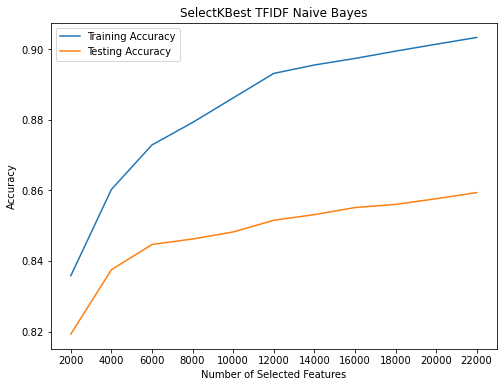

In [33]:
avg_train_Accuracy = [0.8358166666666665, 0.86025, 0.8728444444444443, 0.8792055555555555, 0.8861555555555556, 0.8930944444444444, 0.8954777777777778, 0.8973333333333334, 0.8993999999999998, 0.9013611111111111, 0.903277777777778]
avg_test_Accuracy = [0.8192999999999999, 0.8375, 0.8446499999999999, 0.8462000000000002, 0.8482, 0.8514999999999999, 0.8530999999999999, 0.8551, 0.8560000000000001, 0.8575999999999999, 0.8593500000000001]

plt.plot(list(range(2000,24000,2000)), avg_train_Accuracy)
plt.plot(list(range(2000,24000,2000)), avg_test_Accuracy)
plt.xlabel("Number of Selected Features")
plt.ylabel("Accuracy")
plt.title("SelectKBest TFIDF Naive Bayes")
plt.xticks(range(2000, 24000, 2000))
plt.legend(["Training Accuracy", "Testing Accuracy"])
plt.show()

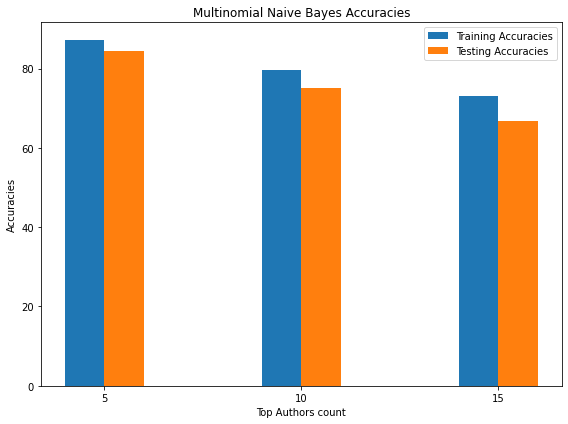

In [34]:
train_Accuracy =[0.8728444444444443*100,79.56622222222223,73.07953216374269]
test_Accuracy =[0.8446499999999999*100,75.224,66.8280701754386]


Labels = [5,10,15]
X_axis = np.arange(len(Labels))
length = np.arange(len(Labels))
width = 0.2
fig, x1 = plt.subplots()
rects1 = x1.bar(X_axis - width/2, train_Accuracy, width, label='Training Accuracies')
rects2 = x1.bar(X_axis + width/2, test_Accuracy, width, label='Testing Accuracies')
x1.set_ylabel('Accuracies')
x1.set_title('Multinomial Naive Bayes Accuracies')
x1.set_xticks(X_axis)
x1.set_xticklabels(Labels)
x1.set_xlabel("Top Authors count")

x1.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] = (8,6)
plt.show()

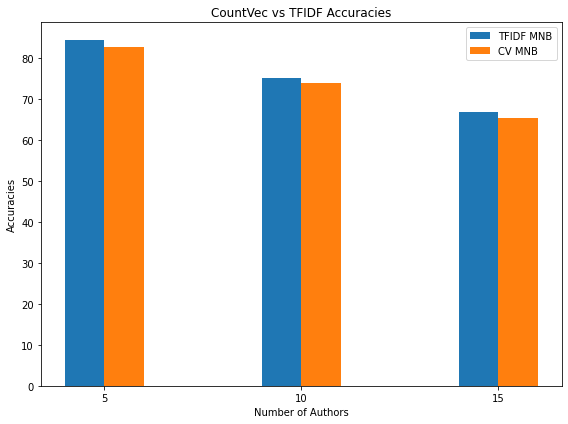

In [35]:
tf_mnb_testing_acc =[0.8446499999999999*100,75.224,66.8280701754386]
cv_mnb_testing_acc =[0.8271*100,73.90800000000002,65.24210526315789]

labels = [5,10,15]
x = np.arange(len(labels))
length = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects3 = ax.bar(x - width/2, tf_mnb_testing_acc, width, label='TFIDF MNB')
rects4 = ax.bar(x + width/2, cv_mnb_testing_acc, width, label='CV MNB')
ax.set_ylabel('Accuracies')
ax.set_title('CountVec vs TFIDF Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")

ax.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] = (8,6)
plt.show()
